# Flight Data Analysis 

This notebook aims to extract useful and interesting insights of flight data.

## Phase 1: Importing Libraries and Overview of the Dataset

The first step of this project is to load all the necessary packages.

In [31]:
import pandas as pd
import numpy as np
import time
import datetime
import airportsdata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from collections import OrderedDict
from mpl_toolkits.basemap import Basemap

After importing the libraries, I read the file that contains the information related to the status of all the domestic flights in the United States between the period 1st November, 2021 and 31st December, 2021. The dataset consists of 1099444 rows and 110 columns.

The initial step is to read the flights.csv file and storing it in a Pandas Dataframe. Additionally, I record the the time taken to read this large file.

In [32]:
%%time
df_flights = pd.read_csv('flights.csv',low_memory=False)
df_flights.info()
df_info = pd.DataFrame(df_flights.dtypes).T.rename(index={0:'Column_Type'})
df_info = df_info.append(pd.DataFrame(df_flights.isnull().sum()).T.rename(index={0:'Null_Values'}))
df_info = df_info.append(pd.DataFrame(df_flights.isnull().sum()/df_flights.shape[0]*100).T.rename(index={0:'Null_Values_Percentage'}))
pd.set_option('display.max_columns', None)
df_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099444 entries, 0 to 1099443
Columns: 110 entries, year to empty_col
dtypes: float64(70), int64(21), object(19)
memory usage: 922.7+ MB
Wall time: 15.3 s


,year,quarter,month,dayofmonth,dayofweek,flightdate,reporting_airline,dot_id_reporting_airline,iata_code_reporting_airline,tail_number,flight_number_reporting_airline,originairportid,originairportseqid,origincitymarketid,origin,origincityname,originstate,originstatefips,originstatename,originwac,destairportid,destairportseqid,destcitymarketid,dest,destcityname,deststate,deststatefips,deststatename,destwac,crsdeptime,deptime,depdelay,depdelayminutes,depdel15,departuredelaygroups,deptimeblk,taxiout,wheelsoff,wheelson,taxiin,crsarrtime,arrtime,arrdelay,arrdelayminutes,arrdel15,arrivaldelaygroups,arrtimeblk,cancelled,cancellationcode,diverted,crselapsedtime,actualelapsedtime,airtime,flights,distance,distancegroup,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,firstdeptime,totaladdgtime,longestaddgtime,divairportlandings,divreacheddest,divactualelapsedtime,divarrdelay,divdistance,div1airport,div1airportid,div1airportseqid,div1wheelson,div1totalgtime,div1longestgtime,div1wheelsoff,div1tailnum,div2airport,div2airportid,div2airportseqid,div2wheelson,div2totalgtime,div2longestgtime,div2wheelsoff,div2tailnum,div3airport,div3airportid,div3airportseqid,div3wheelson,div3totalgtime,div3longestgtime,div3wheelsoff,div3tailnum,div4airport,div4airportid,div4airportseqid,div4wheelson,div4totalgtime,div4longestgtime,div4wheelsoff,div4tailnum,div5airport,div5airportid,div5airportseqid,div5wheelson,div5totalgtime,div5longestgtime,div5wheelsoff,div5tailnum,empty_col
Column_Type,int64,int64,int64,int64,int64,object,object,int64,object,object,int64,int64,int64,int64,object,object,object,int64,object,int64,int64,int64,int64,object,object,object,int64,object,int64,int64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,object,float64,object,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Null_Values,0,0,0,0,0,0,0,0,0,3255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16322,16335,16335,16335,16335,0,16558,16558,17189,17189,0,17189,18860,18860,18860,18860,0,0,1082691,0,0,18860,18860,0,0,0,898621,898621,898621,898621,898621,1094184,1094187,1094187,0,1097337,1097773,1097773,1097337,1097142,1097142,1097142,1097142,1097142,1097142,1097752,1097752,1099417,1099417,1099417,1099417,1099417,1099417,1099438,1099438,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444
Null_Values_Percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.484569,1.485751,1.485751,1.485751,1.485751,0.0,1.506034,1.506034,1.563427,1.563427,0.0,1.563427,1.715413,1.715413,1.715413,1.715413,0.0,0.0,98.47623,0.0,0.0,1.715413,1.715413,0.0,0.0,0.0,81.734131,81.734131,81.734131,81.734131,81.734131,99.521576,99.521849,99.521849,0.0,99.808358,99.848014,99.848014,99.808358,99.790621,99.790621,99.790621,99.790621,99.790621,99.790621,99.846104,99.846104,99.997544,99.997544,99.997544,99.997544,99.997544,99.997544,99.999454,99.999454,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [33]:
# Method downcast_dftypes accepts a dataframe and downcasts 64-bit Integer and Floating point column values in a dataframe to 32-bit values
# return df returns the dataframe
def downcast_dftypes(df):
    start_time = df.memory_usage(deep=True).sum()/1024 **2
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype == "int64"]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int32)
    end_time = df.memory_usage(deep=True).sum()/1024 **2
    saved = (start_time - end_time)/start_time *100
    print(f"Saved {saved:.2f}%")

The reason for downcasting column values is because pandas uses higher-bit for Integer and Floating point values which results in a higher memory usage. Converting them to 32-bit values reduces the memory usage. 

In [34]:
downcast_dftypes(df_flights)
df_flights.info()
#df_flights.to_parquet("flights.parquet.gzip",compression="gzip")
#%%time
#flightdata_df = pd.read_parquet("flights.parquet.gzip")

Saved 20.49%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099444 entries, 0 to 1099443
Columns: 110 entries, year to empty_col
dtypes: float32(70), int32(21), object(19)
memory usage: 541.0+ MB


Each row in the *flights.csv* file correpsonds to the details of one trip made by a particular flight. There are about 1099443 flights recorded during the 4th quarter of 2021 (1st November,2021 to 31st December,2021). Each row is mapped to 100 different columns and the description of the columns can be found [here](file:///C:/Users/chanh/Documents/Flexciton%20Task/readme.html). The most frequently used variables in this notebook are given below along with their description:

* __DAYOFMONTH, DAYOFWEEK, FLIGHTDATE:__ dates of a particular flight
* __IATA_CODE_REPORTING_AIRLINE:__ an identification number used by US DOT to identify a unique airline 
* __ORIGIN, DEST:__ origin and dest hold codes that are attributed by IATA to identify unique airports
* __DEPTIME, ARRTIME:__ actual time at which a flight departed and landed
* __CRSDEPTIME, CRSARRTIME:__ scheduled time at which a flight departed and landed
* __DEPDELAY, ARRDELAY:__ difference (in minutes) between planned and actual time of departure and arrival
* __DISTANCE:__ distance covered (in miles)

In [35]:
# airports holds a dictionary of IATA codes of each airport and the corresponding details such as latitude, longitude, nearest aiports etc.
airports = airportsdata.load('IATA')
# count_flights holds te=he group count of the total number of flights associated with each ORIGIN airport
count_flights = df_flights['origin'].value_counts()
distinct_airport_codes = df_flights['origin'].unique()
# creating a new pandas Dataframe airports_df which holds the distinct_airport_codes, longitude and latitude of each airport
airports_df = pd.DataFrame({'origin':distinct_airport_codes})

* I have created a CSV file - airlines.csv with the reporting_airline code and the corresponding name of the airline 

In [36]:
airlines_names = pd.read_csv('airlines.csv')
airlines_names = airlines_names.set_index('IATA_CODE')
airlines_names_dict = airlines_names['AIRLINE'].to_dict()

In [37]:
# Creating two columns with Ontime, Late and Cancelled status for both departure and arrival
df_flights.loc[df_flights.depdelay.isna(), "dep_status"]="Canceled"
df_flights.loc[df_flights.depdelay <= 0, "dep_status"]="OnTime"
df_flights.loc[df_flights.depdelay > 0, "dep_status"]="Late"
df_flights.loc[df_flights.arrdelay.isna(), "arr_status"]="Canceled"
df_flights.loc[df_flights.arrdelay <= 0, "arr_status"]="OnTime"
df_flights.loc[df_flights.arrdelay > 0, "arr_status"]="Late"

# set_longitude method returns the longitude retrieved from the airportsdata library
def set_longitude(row):
    
    if row['origin'] in airports.keys():
        return airports[row['origin']]['lon']

# set_latitude method returns the latitude retrieved from the airportsdata library
def set_latitude(row):
    if row['origin'] in airports.keys():
        return airports[row['origin']]['lat']
    
airports_df['LONGITUDE'] = airports_df.apply(lambda row: set_longitude(row), axis=1)
airports_df['LATITUDE'] = airports_df.apply(lambda row: set_latitude(row), axis=1)
airports_df = airports_df.dropna()

In [38]:
def set_origin_airport_name(row):
    if row['origin'] in airports.keys():
        return airports[row['origin']]['name']

def set_dest_airport_name(row):
    if row['dest'] in airports.keys():
        return airports[row['dest']]['name']

def set_airline_name(row):
    if row['reporting_airline'] in airlines_names_dict.keys():
        return airlines_names_dict[row['reporting_airline']]
    
df_flights['originairportname'] = df_flights.apply(lambda row: set_origin_airport_name(row), axis=1)
df_flights['destairportname'] = df_flights.apply(lambda row: set_dest_airport_name(row), axis=1)
df_flights['airlinename'] = df_flights.apply(lambda row: set_airline_name(row), axis=1)
airports_df['airportname'] = airports_df.apply(lambda row: set_origin_airport_name(row), axis=1)

# Adding a route column
routes  = pd.Series(df_flights['originairportname'] + ' > ' + df_flights['destairportname'])
df_flights = pd.concat([df_flights, routes.rename("Route")], axis=1)

The Map below gives us an idea of the geographical area covered in this dataset. We plot every airports location which has been traversed by the flights. It also gives us a rough idea of the number of flights recorded at each airport during the last quarter of 2021.

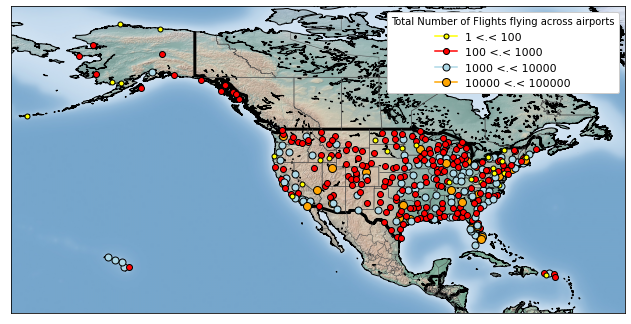

In [41]:
plt.figure(figsize=(11,11))
colors = ['yellow', 'red', 'lightblue', 'orange']
labels = []
size_limits = [1, 100, 1000, 10000, 100000]
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
    
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')

for index, (code,y,x) in airports_df[['origin', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='k',label = labels[ind])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000','10000 <.< 100000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Total Number of Flights flying across airports', frameon = True, framealpha = 1)
plt.show()

## Phase 2: Cleaning the Dataset

### __*2.1 Dates and times*__
* From the flight data csv, we have 6 columns related to date - *YEAR, QUARTER, MONTH, DAYOFMONTH, DAYOFWEEK, and FLIGHTDATE*. I won't be using *YEAR and QUARTER* because the dataset is based on only the 4th quarter of the year 2021. So I will be removing these columns from the dataframe.

In [42]:
df_flights = df_flights.drop(columns=['year','quarter'])

In [43]:
# format_time accepts the floating point/integer values and returns a datetime object (HH:MM)
def format_time(time):
    if pd.isnull(time):
        return np.nan
    else:
        if time == 2400: time = 0
        time = "{0:04d}".format(int(time))
        hour_minute = datetime.time(int(time[0:2]), int(time[2:4]))
        return hour_minute

In [44]:
df_flights['crsdeptime'] = df_flights['crsdeptime'].apply(format_time)
df_flights['deptime'] = df_flights['deptime'].apply(format_time)
df_flights['crsarrtime'] = df_flights['crsarrtime'].apply(format_time)
df_flights['arrtime'] = df_flights['arrtime'].apply(format_time)

* Note: The content of CRSDEPTIME (Scheduled departure time) and CRSARRTIME (scheduled arrival time) variables can be a bit misleading since they don't contain the dates. For example, in row 97229 of the dataframe, the scheduled departure is at 23h32 on 27nd, December. But due to unknown reasons there is a delay of 29 minutes. The DEPTIME (actual departure time) variable indicates 00h11 and we thus don't know if the flight left before time or if there was a large delay. Hence, the DEPDELAY and ARRDELAY variables proves more useful since they directly provides the delays in minutes.

### __*2.2 Dropping Null Columns*__
* This step is fairly simple and straightforward. I have initialized a constant *NULL_THRESHOLD* with a value of 90. I use this constant to pick all the columns with a null_value_percentage greater than this. I remove all the columns that exceed this threshold. 

In [45]:
# Intializing a constant to remove columns that have a higher percentage of null values 
NULL_THRESHOLD = 90
flight_null_series = (df_flights.isnull().sum() / len(df_flights)) * 100
flight_null_series = pd.Series(flight_null_series).where(lambda x: x > NULL_THRESHOLD).dropna()
flight_null_series.index

Index(['cancellationcode', 'firstdeptime', 'totaladdgtime', 'longestaddgtime',
       'divreacheddest', 'divactualelapsedtime', 'divarrdelay', 'divdistance',
       'div1airport', 'div1airportid', 'div1airportseqid', 'div1wheelson',
       'div1totalgtime', 'div1longestgtime', 'div1wheelsoff', 'div1tailnum',
       'div2airport', 'div2airportid', 'div2airportseqid', 'div2wheelson',
       'div2totalgtime', 'div2longestgtime', 'div2wheelsoff', 'div2tailnum',
       'div3airport', 'div3airportid', 'div3airportseqid', 'div3wheelson',
       'div3totalgtime', 'div3longestgtime', 'div3wheelsoff', 'div3tailnum',
       'div4airport', 'div4airportid', 'div4airportseqid', 'div4wheelson',
       'div4totalgtime', 'div4longestgtime', 'div4wheelsoff', 'div4tailnum',
       'div5airport', 'div5airportid', 'div5airportseqid', 'div5wheelson',
       'div5totalgtime', 'div5longestgtime', 'div5wheelsoff', 'div5tailnum',
       'empty_col'],
      dtype='object')

In [46]:
df_flights = df_flights.drop(columns = flight_null_series.index.values.tolist())

* Filling the NA values corresponding to - *DEPDELAY, ARRDELAY, CARRIERDELAY, WEATHERDELAY, NASDELAY, SECURITYDELAY, LATEAIRCRAFTDELAY* with 0. I did this to have consistent data. Because the flights that have a delay due to one of the factors above, the rest of the parameters are set to 0. 

In [47]:
df_flights['carrierdelay'] = df_flights['carrierdelay'].fillna(0)
df_flights['weatherdelay'] = df_flights['weatherdelay'].fillna(0)
df_flights['nasdelay'] = df_flights['nasdelay'].fillna(0)
df_flights['securitydelay'] = df_flights['securitydelay'].fillna(0)
df_flights['lateaircraftdelay'] = df_flights['lateaircraftdelay'].fillna(0)
df_flights.depdelay = df_flights.depdelay.fillna(0)
df_flights.arrdelay = df_flights.arrdelay.fillna(0)

* Columns listed below will be dropped as we can't draw any useful insights from them. 

In [48]:
columns_to_remove = ['tail_number', 'origincitymarketid', 'originairportseqid', 'originstatefips', 'originwac',
                       'destairportseqid', 'destcitymarketid', 'deststatefips', 'destwac', 'depdelayminutes', 
                       'departuredelaygroups', 'deptimeblk', 'taxiout', 'wheelsoff', 'wheelson', 'taxiin', 
                       'arrdelayminutes', 'arrivaldelaygroups', 'arrtimeblk']
df_flights.drop(columns_to_remove, axis = 1, inplace = True)

## Phase 3: Exploratory Analysis

### *3.1 Airlines: using airlines statistics as a metric to draw insights*

* The output below shows the the total number of flights operated by each airline. It also gives us a picture of minimum_delay, maximum_delay, and average_delay encountered by each airline. 

In [49]:
#function get_details accepts a groupby object and returns a dictionary with the details of each airline 
def get_details(group):
    return {'flight_count': group.count(), 'min_delay': group.min(), 'max_delay': group.max(), 'avg_delay': group.mean()}

grouped_departure_delay_by_airline = df_flights['depdelay'].groupby(df_flights['airlinename'])
df_airline_stats = grouped_departure_delay_by_airline.apply(get_details).unstack()
df_airline_stats.sort_values('avg_delay')

,flight_count,min_delay,max_delay,avg_delay
airlinename,,,,
Endeavor Air,43025.0,-27.0,1260.0,2.890296
Republic Airways,55141.0,-33.0,1224.0,2.941495
American Eagle Airlines Inc.,45171.0,-25.0,1557.0,4.693343
Hawaiian Airlines Inc.,11955.0,-19.0,1462.0,5.736763
PSA Airlines,40262.0,-37.0,1520.0,6.203741
Delta Air Lines Inc.,138898.0,-60.0,1227.0,8.431215
Horizon Air,15085.0,-38.0,754.0,8.807159
American Airlines Inc.,144732.0,-40.0,3001.0,9.498197
Alaska Airlines Inc.,33778.0,-45.0,844.0,10.327077


*__A small case study on Mesa Airlines__:*
* Mesa Airlines has recorded the highest average_delay amongst other airlines. Why? This can be analyzed by extracting the top 3 airports where Mesa Airlines has the highest departure count. On analyzing, Mesa Airlines uses George Bush Intercontinental Houston Airport, Dallas Fort Worth International Airport and Phoenix Sky Harbor International Airport as frequent departing airports. On further analysis on these airports, Dallas Airport is the 2nd most busiest airport, Phoenix Airport being the 7th most busiest and Houston Airport being the 12th most busiest airport, in terms of the number of flights departed. On grouping origin_airport and flight_date, I obtained the count of the number of flights departing from each airport on a given day. By applying the mean function gives us the average number of flights departing from each airport. This procedure can be used as a metric to find the busiest airports.   

In [90]:
mesa_group = df_flights.groupby(df_flights[df_flights['reporting_airline']=='YV']['originairportname']).size()
df_mesa_airlines = pd.DataFrame(mesa_group)
df_mesa_airlines.rename(columns={0 :'flight_count'}, inplace=True)
df_mesa_airlines.sort_values('flight_count',ascending=False)
#pd.DataFrame(mesa_group['depdel15'].sum()).sort_values('depdel15',ascending=False)

,flight_count
originairportname,
George Bush Intercontinental Houston Airport,4122
Dallas Fort Worth International Airport,4113
Phoenix Sky Harbor International Airport,2493
Washington Dulles International Airport,2088
Chicago O'Hare International Airport,861
...,...
Robert Gray Army Air Field Airport,2
Flagstaff Pulliam Airport,1
Northwest Arkansas Regional Airport,1


In [91]:
busy_airports = df_flights.groupby(['origin','flightdate'])['origin'].count()

In [92]:
df_busy_airports = pd.DataFrame(busy_airports).rename(columns={'origin':'Avg_number_of_flights'}).sort_values('flightdate')
mean_departures_df = pd.DataFrame(df_busy_airports.groupby('origin').mean('Avg_number_of_flights').sort_values('Avg_number_of_flights',ascending=False))
mean_departures_df = mean_departures_df.reset_index()
mean_departures_df['AirportName'] = mean_departures_df.apply(lambda row: set_origin_airport_name(row), axis=1)
mean_departures_df

,origin,Avg_number_of_flights,AirportName
0,ATL,866.950820,Hartsfield Jackson Atlanta International Airport
1,DFW,769.885246,Dallas Fort Worth International Airport
2,ORD,742.344262,Chicago O'Hare International Airport
3,DEN,714.770492,Denver International Airport
4,CLT,544.786885,Charlotte Douglas International Airport
...,...,...,...
358,DLG,1.000000,Dillingham Airport
359,OTH,1.000000,Southwest Oregon Regional Airport
360,DIK,1.000000,Dickinson Theodore Roosevelt Regional Airport
361,AKN,1.000000,King Salmon Airport


* __*mean_departures_df*__ dataframe holds the average number of flights flying from each airport on a given day. It also holds the average departure and arrival delays. The higher the average number of flights reported at a given airport, the busier it is.

In [111]:
avg_depdelay_df = pd.DataFrame(df_flights.groupby(['origin'])['depdelay'].mean())
avg_arrdelay_df = pd.DataFrame(df_flights.groupby(['origin'])['arrdelay'].mean())
mean_departures_df = pd.merge(mean_departures_df, avg_depdelay_df[['depdelay']], on="origin", how="left")
mean_departures_df = pd.merge(mean_departures_df, avg_arrdelay_df[['arrdelay']], on="origin", how="left")
mean_departures_df.rename(columns={'depdelay' :'Avg_depdelay'}, inplace=True)
mean_departures_df.rename(columns={'arrdelay' :'Avg_arrdelay'}, inplace=True)
mean_departures_df

,origin,Avg_number_of_flights,AirportName,Avg_depdelay,Avg_arrdelay
0,ATL,866.950820,Hartsfield Jackson Atlanta International Airport,6.725305,1.791676
1,DFW,769.885246,Dallas Fort Worth International Airport,9.586440,2.617295
2,ORD,742.344262,Chicago O'Hare International Airport,9.451449,1.428571
3,DEN,714.770492,Denver International Airport,15.287791,6.669044
4,CLT,544.786885,Charlotte Douglas International Airport,4.058408,-1.366063
...,...,...,...,...,...
358,DLG,1.000000,Dillingham Airport,29.898306,32.254238
359,OTH,1.000000,Southwest Oregon Regional Airport,60.477272,53.613636
360,DIK,1.000000,Dickinson Theodore Roosevelt Regional Airport,32.727272,39.818180
361,AKN,1.000000,King Salmon Airport,7.271186,3.864407


### *3.2 Top 10 Busiest Airports* 

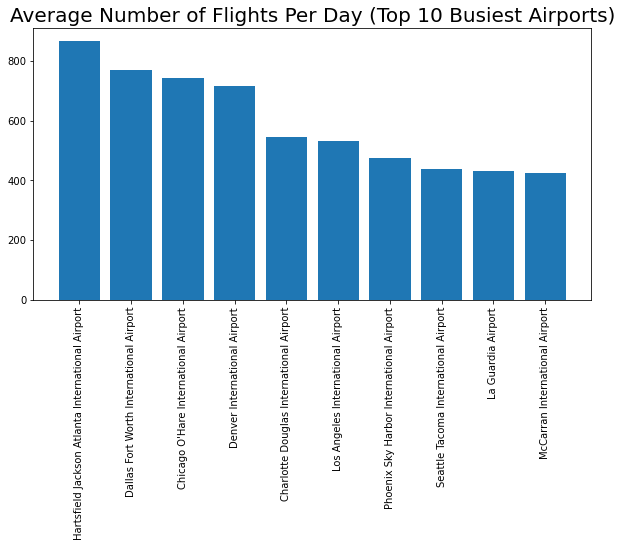

In [53]:
# Top 10 busiest airports:
fig = plt.figure(figsize=[10, 5])
plt.bar(mean_departures_df['AirportName'][0:10], height=mean_departures_df['Count'][0:10])
plt.title("Average Number of Flights Per Day (Top 10 Busiest Airports)", fontsize=20)
plt.xticks(rotation = 90)
plt.show()

### *3.3 Average Departure and Arrival Delays of Flights in the top 10 Busies Airports*

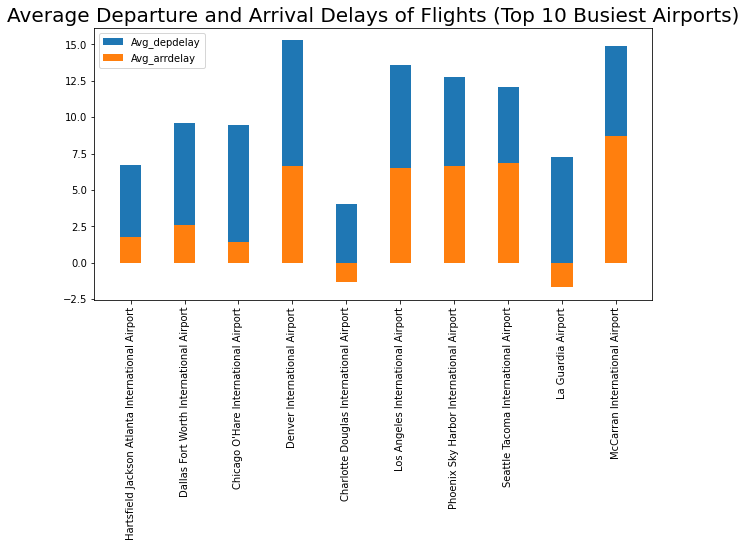

In [123]:
# Departure and Arrival Top 10 busiest airports:
fig = plt.figure(figsize=[10, 5])
x_axis = np.arange(len(mean_departures_df['AirportName'][0:10]))
plt.bar(mean_departures_df['AirportName'][0:10], mean_departures_df['Avg_depdelay'][0:10], width=0.4, label = 'Avg_depdelay')
plt.bar(mean_departures_df['AirportName'][0:10], mean_departures_df['Avg_arrdelay'][0:10], width=0.4, label = 'Avg_arrdelay')
plt.title("Average Departure and Arrival Delays of Flights (Top 10 Busiest Airports)", fontsize=20)
plt.xticks(rotation = 90)
plt.legend()
plt.show()

### *3.4  Percentage of Flights each Airline operates* 

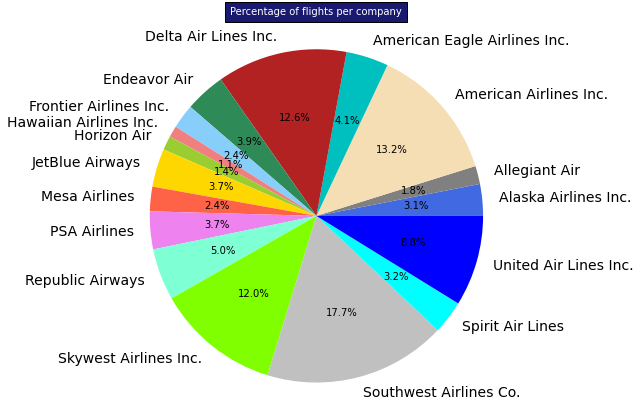

In [54]:
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse', 'silver', 'cyan', 'blue']
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
labels = [s for s in  df_airline_stats.index]
sizes  = df_airline_stats['flight_count'].values
patches, texts, autotexts = ax1.pie(sizes, labels = labels, shadow=False, autopct='%1.1f%%', colors=colors, radius=2)
for i in range(len(airlines_names_dict)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('Percentage of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=10, pad=16)
ax1.axis('equal')

plt.show() 

### *3.5 Distribution of Departure and Arrival Delays* 

depdelay 
Minimum:-60.00
Mean:10.34
Median:-1.00
Mode:-5.00
Maximum:3001.00

arrdelay 
Minimum:-82.00
Mean:3.69
Median:-6.00
Mode:0.00
Maximum:2976.00



C:\Users\chanh\AppData\Local\Temp/ipykernel_20828/1381439888.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\chanh\AppData\Local\Temp/ipykernel_20828/1381439888.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


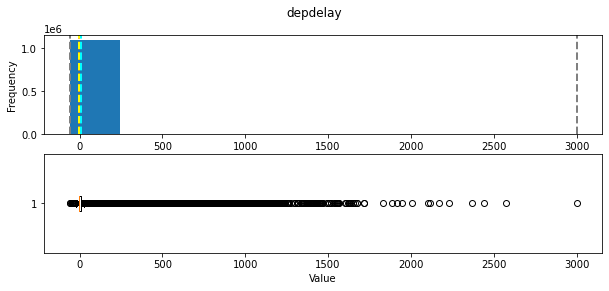

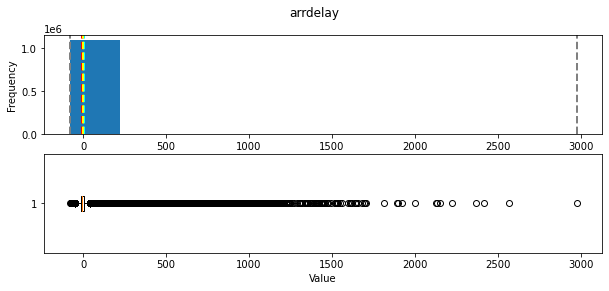

In [55]:
# show_distribution lists the summary stats and distribution for the columns - depdelay and arrdelay
def show_distribution(var_data):

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    print(var_data.name,'\nMinimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,4))

    # Plot the histogram   
    ax[0].hist(var_data)
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot   
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel('Value')

    # Add a title to the Figure
    fig.suptitle(var_data.name)

    # Show the figure
    fig.show()

# Call the function for each delay field
delayFields = ['depdelay','arrdelay']
for col in delayFields:
    show_distribution(df_flights[col])

There are a outliers at the lower and upper ends of both variables - particularly at the upper end.

Let's trim the data so that we include only rows where the values for these fields are within the 1st and 90th percentile.

depdelay 
Minimum:-12.00
Mean:-1.71
Median:-3.00
Mode:-5.00
Maximum:15.00

arrdelay 
Minimum:-37.00
Mean:-8.39
Median:-9.00
Mode:0.00
Maximum:32.00



C:\Users\chanh\AppData\Local\Temp/ipykernel_20828/1381439888.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\chanh\AppData\Local\Temp/ipykernel_20828/1381439888.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


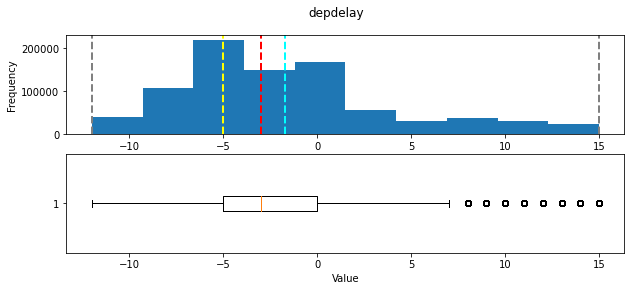

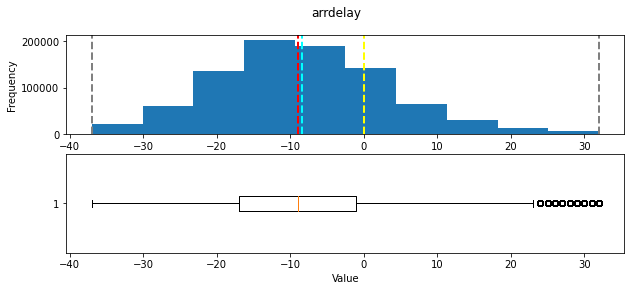

In [56]:
df_flights_copy = df_flights.copy()
# Trim outliers for arrdelay based on 1% and 90% percentiles
df_flights_copy = df_flights_copy[df_flights_copy.arrdelay < df_flights_copy.arrdelay.quantile(0.90)]
df_flights_copy = df_flights_copy[df_flights_copy.arrdelay > df_flights_copy.arrdelay.quantile(0.01)]

# Trim outliers for depdelay based on 1% and 90% percentiles
df_flights_copy = df_flights_copy[df_flights_copy.depdelay < df_flights_copy.depdelay.quantile(0.90)]
df_flights_copy = df_flights_copy[df_flights_copy.depdelay > df_flights_copy.depdelay.quantile(0.01)]

# View the revised distributions
for col in delayFields:
    show_distribution(df_flights_copy[col])

From the above departure delay histogram, results show that:
* approximately 585,000 flights experience a departure delay between -12.5min and 0min (early departure) 
* approximately 273,000 flights experience a departure delay between 0min and 15min (late departure)
* approximately 203,000 flights experience a departure delay above 15mins. These flights have been delayed due to reasons such as weatherdelay, carrierdelay, nasdelay or securitydelay. I will discuss this in upcoming sections.

<br>From the above arrival delay histogram, results show that:
* approximately 651,000 flights experience an arrival delay between -40min and 0min (early arrival) 
* approximately 212,000 flights experience an arrival delay between 0min and 30min (late arrival)
* approximately 118,000 flights experience an arrival delay above 30mins. These flights have been delayed due to reasons such as weatherdelay, carrierdelay, nasdelay or securitydelay. I will discuss this in upcoming sections.

In [57]:
#df_flights_copy[(df_flights_copy['depdelay']>=0) & (df_flights_copy['depdelay']<15)]

For the purpose of convenience, I add the airport_name and airline_name to df_flights dataframe

### *3.6 Average departure delays w.r.t Airports* 

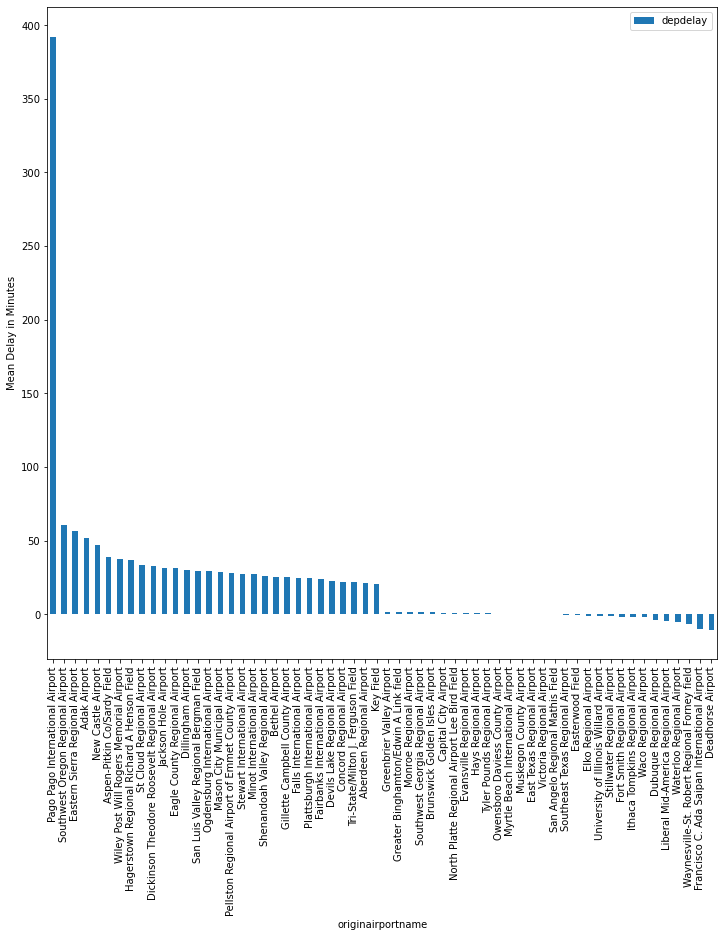

In [116]:
airport_group = df_flights.groupby(df_flights.originairportname)

mean_departure_delays = pd.DataFrame(airport_group['depdelay'].mean()).sort_values('depdelay', ascending=False)
large_delay_df = mean_departure_delays[0:30].copy()
small_delay_df = mean_departure_delays[-30:].copy()
frames = [large_delay_df, small_delay_df]
mean_depdelay = pd.concat(frames)
mean_depdelay.plot(kind = "bar", figsize=(12,12), ylabel="Mean Delay in Minutes")
plt.show()

* There are about 352 unique airports in the given dataset. I have only extracted 60 airports with their mean departure delay values, the first 30 in descending order of mean and the last 30 in ascending order of mean. This is just to make the visualization easier.
* Pago Pago International Airport seems to have the highest average departure and arrival delays compared to the rest of the airports. It has an average departure and arrival delay of approximately 390min. On going through the dataset, Pago Pago International Airport has had only 3 departures, of which one of the departures had been delayed by 1037 minutes. This was due to a carrier delay. All 3 flights that departed from Pago Pago International airport suffered a departure and arrival delay of atleast 50min. This is a misleading metric while visualizing delays specific to airports.

### *3.7 Average arrival delays w.r.t Airports* 

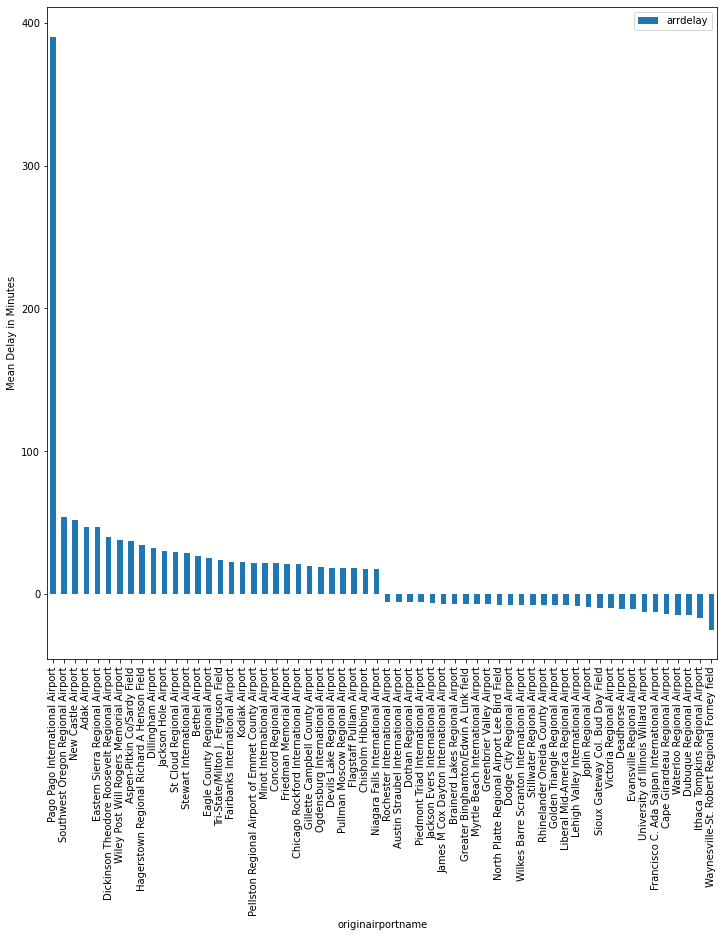

In [117]:
mean_arrival_delays = pd.DataFrame(airport_group['arrdelay'].mean()).sort_values('arrdelay', ascending=False)
large_arrdelay_df = mean_arrival_delays[0:30].copy()
small_arrdelay_df = mean_arrival_delays[-30:].copy()
frames = [large_arrdelay_df, small_arrdelay_df]
mean_arrdelay = pd.concat(frames)
mean_arrdelay.plot(kind = "bar", figsize=(12,12), ylabel="Mean Delay in Minutes")
plt.show()

### *3.8 Routes with high arrival delays* 

In [118]:
# Group by routes
route_group = df_flights.groupby(df_flights.Route)
pd.DataFrame(route_group['arrdel15'].sum()).sort_values('arrdel15', ascending=False)

,arrdel15
Route,
McCarran International Airport > Los Angeles International Airport,399.0
Seattle Tacoma International Airport > Ted Stevens Anchorage International Airport,393.0
Los Angeles International Airport > San Francisco International Airport,389.0
Orlando International Airport > Newark Liberty International Airport,384.0
Newark Liberty International Airport > Orlando International Airport,357.0
...,...
Asheville Regional Airport > Chicago Midway International Airport,0.0
Rick Husband Amarillo International Airport > Austin Bergstrom International Airport,0.0
Denver International Airport > Pensacola Regional Airport,0.0


### *3.9 Number of flights flying on each day of the week* 

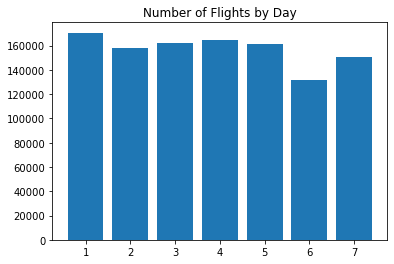

In [160]:
total_flights_by_day = df_flights.groupby(df_flights.dayofweek)['flights'].sum()
plt.bar(total_flights_by_day.index,total_flights_by_day.values)
plt.title("Number of Flights by Day")
plt.show()

### *3.10 Departure delays w.r.t Airlines* 

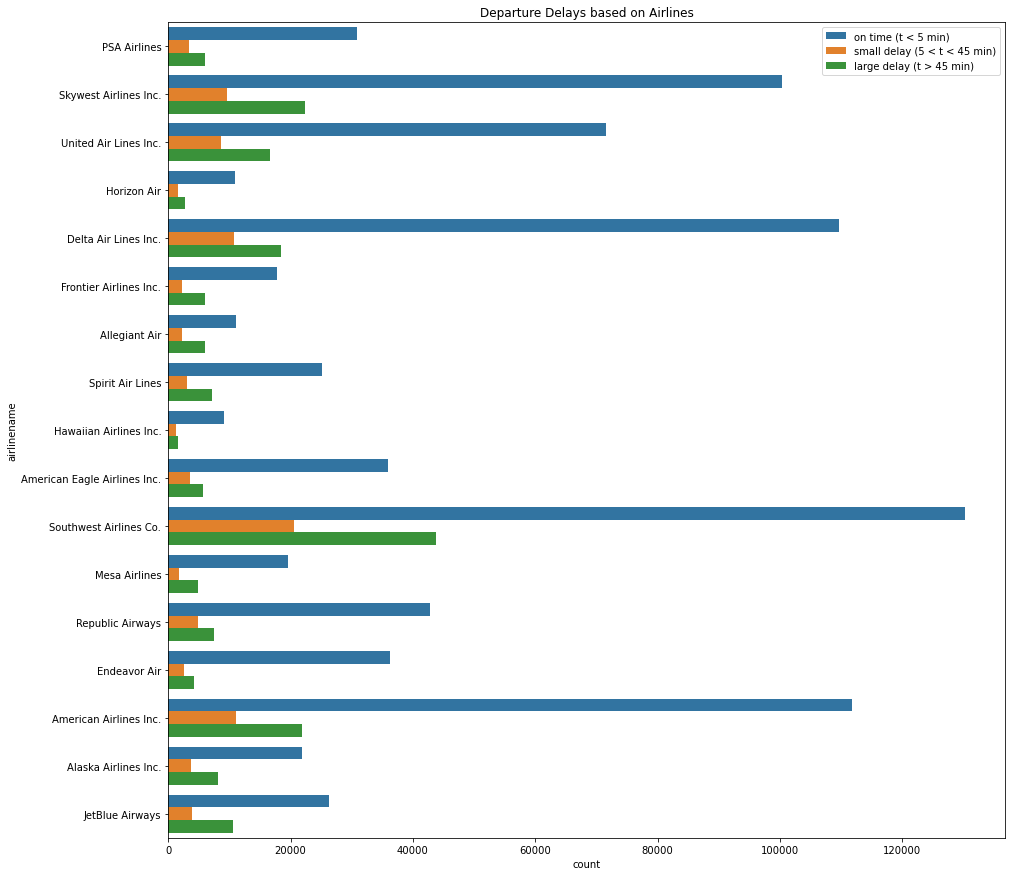

In [550]:
delay_type = lambda time: 1 if (time>5 and time<15)  else (2 if time>15 else 0)
df_flights['delaytype'] = df_flights['arrdelay'].apply(delay_type)
fig = plt.figure(1, figsize=(15,15))
sns.countplot(y='airlinename', hue="delaytype", data=df_flights)
plt.title("Departure Delays based on Airlines")
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

### *3.11 Distribution of Arrival and Departure Status* 

In [126]:
depStatus = df_flights.groupby('dep_status')['dep_status'].count()
arrStatus = df_flights.groupby('arr_status')['arr_status'].count()
print(depStatus)
print()
print(arrStatus)
print()
print(df_flights[])

dep_status
Canceled     16335
Late        413882
OnTime      669227
Name: dep_status, dtype: int64

arr_status
Canceled     18860
Late        379051
OnTime      701533
Name: arr_status, dtype: int64


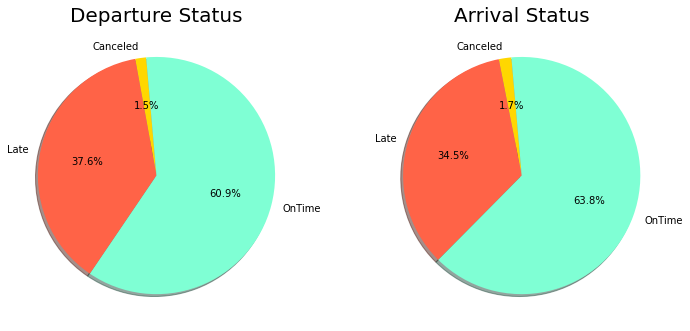

In [133]:
fig = plt.figure(figsize=[12, 12])
colors = ['gold', 'tomato', 'aquamarine']
ax = fig.add_subplot(221)
ax.pie(depStatus, labeldistance=1.1, labels=depStatus.index, startangle=95, autopct='%1.1f%%', shadow=True, colors=colors)
ax.set_title("Departure Status", fontsize=20);
#plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.2, color='white'))

ax2 = fig.add_subplot(222)
ax2.pie(arrStatus, labeldistance=1.1, labels=arrStatus.index, startangle=95, autopct='%1.1f%%', shadow=True, colors=colors)
ax2.set_title("Arrival Status", fontsize=20);
#plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.2, color='white'))
plt.show()

* Out of __*1099444*__ flights, __*669561(60.9%)*__ flights in Nov and Dec of 2021 departed on time, __*413390(37.6%)*__ were delayed and __*16492(1.5%)*__ of flights were canceled.
* Out of __*1099444*__ flights, __*701445(63.8%)*__ flights in Nov and Dec of 2021 arrived on time, __*379308(34.5%)*__ were delayed and __*18690(1.7%)*__ of flights were cancelled.

In [156]:
depAir = df_flights.loc[df_flights['dep_status'] == 'Late'].groupby(['origin','dep_status'])['dep_status'].count().unstack().sort_values('Late',ascending=False)
arrAir = df_flights.loc[df_flights['arr_status'] == 'Late'].groupby(['origin','arr_status'])['arr_status'].count().unstack().sort_values('Late',ascending=False)
depAir = depAir.reset_index()
arrAir = arrAir.reset_index()
depAir['airportname'] = depAir.apply(lambda row: set_origin_airport_name(row), axis=1)
arrAir['airportname'] = arrAir.apply(lambda row: set_origin_airport_name(row), axis=1)
depAir

dep_status,origin,Late,airportname
0,DEN,23248,Denver International Airport
1,ATL,17213,Hartsfield Jackson Atlanta International Airport
2,DFW,16786,Dallas Fort Worth International Airport
3,ORD,15695,Chicago O'Hare International Airport
4,LAX,13878,Los Angeles International Airport
...,...,...,...
358,ALO,5,Waterloo Regional Airport
359,SPN,5,Francisco C. Ada Saipan International Airport
360,TBN,5,Waynesville-St. Robert Regional Forney field
361,PPG,3,Pago Pago International Airport


### *3.12 Top 10 Airports with the highest number of Late Departures and Late Arrivals*

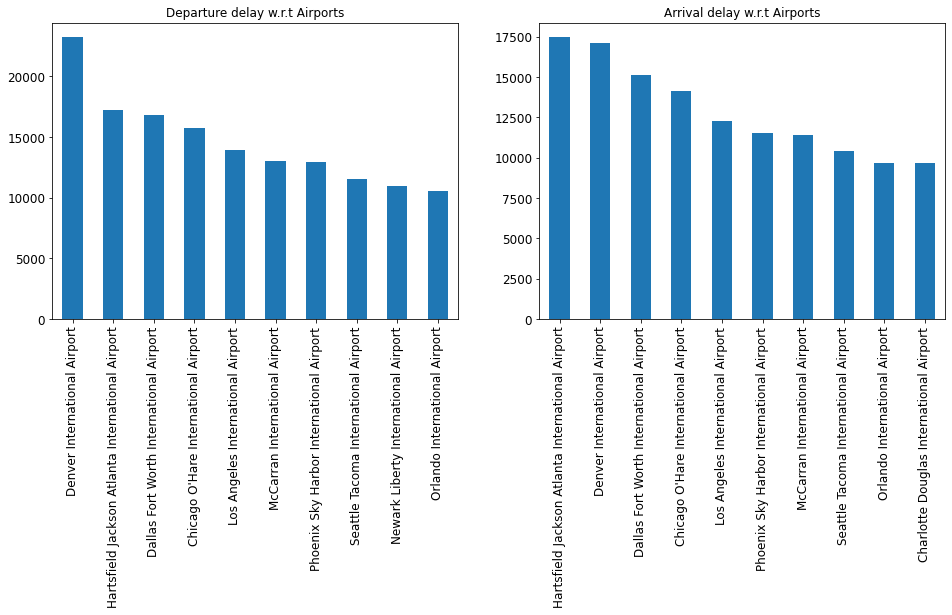

In [167]:
fig = plt.figure(figsize=[16, 12])
ax = fig.add_subplot(221)
depAir['Late'][0:10].plot(kind='bar', ax=ax, title ="Departure delay w.r.t Airports",  legend=False, fontsize=12)
ax.set_xticklabels(depAir['airportname'][0:10])
ax2 = fig.add_subplot(222)
arrAir['Late'][0:10].plot(kind='bar', ax=ax2, title ="Arrival delay w.r.t Airports",  legend=False, fontsize=12)
ax2.set_xticklabels(arrAir['airportname'][0:10])
plt.show()

### *3.13 Best and Worst Airlines w.r.t Departure Delays:*

In [200]:
depCarrier = df_flights.loc[df_flights['dep_status'] == 'Late'].groupby(['reporting_airline','dep_status'])['dep_status'].count().unstack('dep_status')
depCarrier = depCarrier.reset_index()
depCarrier['airlinename'] = depCarrier.apply(lambda row: set_airline_name(row), axis=1)

In [201]:
depCarrier['Total_flights'] = df_flights.groupby('reporting_airline').size().values
depCarrier['Percentage'] = (depCarrier['Late']/depCarrier['Total_flights'])*100
depCarrier = depCarrier.sort_values('Percentage',ascending=False)
depCarrier

dep_status,reporting_airline,Late,airlinename,Total_flights,Percentage
14,WN,112704,Southwest Airlines Co.,194737,57.874980
6,G4,8948,Allegiant Air,19338,46.271590
13,UA,41833,United Air Lines Inc.,96753,43.236902
2,AS,14362,Alaska Airlines Inc.,33778,42.518799
3,B6,17116,JetBlue Airways,40806,41.944812
5,F9,10224,Frontier Airlines Inc.,25963,39.379116
9,NK,13267,Spirit Air Lines,35426,37.449896
7,HA,4287,Hawaiian Airlines Inc.,11955,35.859473
1,AA,50231,American Airlines Inc.,144732,34.706216
15,YV,9024,Mesa Airlines,26156,34.500688


* __*Southwest Airlines Co.*__ has the __*highest percentage(57.8%)*__ of late departures, whereas __*Endeavor Air*__ has the __*lowest percentage(17.04%)*__ of late departures.

### *3.13 Best and worst Airlines w.r.t total flights cancelled*

In [204]:
cancelled_flights = df_flights.loc[df_flights['dep_status'] == 'Canceled'].groupby(['reporting_airline','dep_status'])['dep_status'].count().unstack('dep_status')
cancelled_flights = cancelled_flights.reset_index()
cancelled_flights['airlinename'] = cancelled_flights.apply(lambda row: set_airline_name(row), axis=1)
cancelled_flights = cancelled_flights.sort_values('Canceled',ascending=False)
cancelled_flights

dep_status,reporting_airline,Canceled,airlinename
11,OO,3311,Skywest Airlines Inc.
13,UA,1817,United Air Lines Inc.
1,AA,1759,American Airlines Inc.
4,DL,1613,Delta Air Lines Inc.
14,WN,1565,Southwest Airlines Co.
2,AS,1203,Alaska Airlines Inc.
15,YV,1014,Mesa Airlines
9,NK,967,Spirit Air Lines
3,B6,937,JetBlue Airways
6,G4,789,Allegiant Air


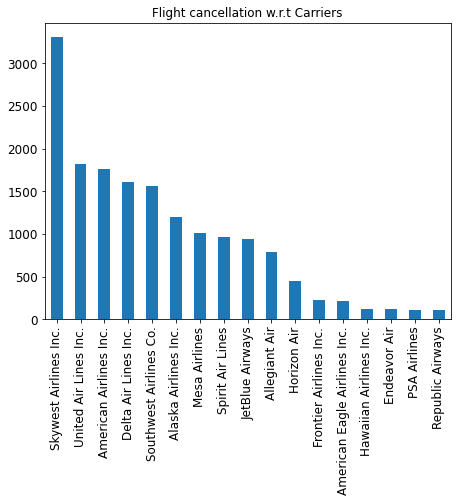

In [213]:
fig = plt.figure(figsize=[16, 12])
ax = fig.add_subplot(221)
cancelled_flights.plot(kind='bar', ax=ax, title ="Flight cancellation w.r.t Carriers",  legend=False, fontsize=12)
ax.set_xticklabels(cancelled_flights['airlinename'])
plt.show()

* __*Skywest Airlines Inc.*__ has cancelled about __*3311*__ flights during the months of Nov and Dec of 2021, making it the airline with the largest number of cancelled flights. Whereas, __*Republic Airways*__ has cancelled about __*107*__ flights, making it the airline with the least number of cancelled flights. 
* However, a more adequate approach to find the best and worst airline performer could be, by comparing the ratio of total number of flights operated during a certain period with the number of flights cancelled during the same period.

## Phase 4: Conclusion

* This notebook consists of 3 phases - Overview of the dataset, Cleaning/Preprocessing the dataset and Exploratory Data Analysis. The exploratory analysis was aimed at getting a better understanding of the departure and arrival dealys with respect to both airports and airline companies. In the process of data exploration, I have found some interesting insights such as the Mesa Airline case study, how data can be decieving - Pago Pago international airport, generating a metric to find the busiest airports, and a few more which are listed in this notebook. 